# Setup

In [26]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')

from utils.paths import gaul_path
from spectral_index import extract_imagery, calculate_lst, get_sample_info
from gee_helpers import authenticate_ee, request_gee_image, get_utm_crs

import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import ee
import eemont
import xarray as xr
import rioxarray as rxr
import xee
import geemap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
authenticate_ee()

# GAUL Boundaries

In [3]:
gaul_gdf = gpd.read_file(gaul_path)
gaul_gdf

,iso3_code,map_code,gaul0_code,gaul0_name,gaul1_code,gaul1_name,gaul2_code,gaul2_name,continent,disp_en,geometry
0,ATA,ATA,371,Antarctica,4108,Administrative Unit Not Available,145675,Administrative Unit Not Available,--,Antarctica,"MULTIPOLYGON (((-57.26548 -63.22741, -57.25572..."
1,GRL,DNK,372,Greenland,4109,Administrative Unit Not Available,145676,Administrative Unit Not Available,--,Greenland,"MULTIPOLYGON (((-32.42781 83.61441, -32.33833 ..."
2,xAB,xAB,100,Abyei,1000,Administrative Unit Not Available,100000,Administrative Unit Not Available,Africa,Abyei,"POLYGON ((28.42578 10.16719, 28.4349 10.16719,..."
3,DZA,DZA,101,Algeria,1001,Adrar,100001,Adrar,Africa,"Adrar, Adrar, Algeria","POLYGON ((-0.17099 27.76973, -0.17086 27.77254..."
4,DZA,DZA,101,Algeria,1001,Adrar,100002,Akabili,Africa,"Akabili, Adrar, Algeria","POLYGON ((0.91251 26.22968, 0.91186 26.22906, ..."
...,...,...,...,...,...,...,...,...,...,...,...
45518,SLV,SLV,191,El Salvador,2025,Sonsonate,145716,Sonsonate Norte,America,"Sonsonate Norte, Sonsonate, El Salvador","POLYGON ((-89.68587 13.79212, -89.68698 13.790..."
45519,SLV,SLV,191,El Salvador,2025,Sonsonate,145717,Sonsonate Oeste,America,"Sonsonate Oeste, Sonsonate, El Salvador","POLYGON ((-89.81993 13.66957, -89.81818 13.668..."
45520,SLV,SLV,191,El Salvador,2026,Usulután,145718,Usulután Este,America,"Usulután Este, Usulután, El Salvador","MULTIPOLYGON (((-88.46403 13.20764, -88.46403 ..."
45521,SLV,SLV,191,El Salvador,2026,Usulután,145719,Usulután Norte,America,"Usulután Norte, Usulután, El Salvador","POLYGON ((-88.50626 13.45661, -88.50713 13.455..."


<Axes: >

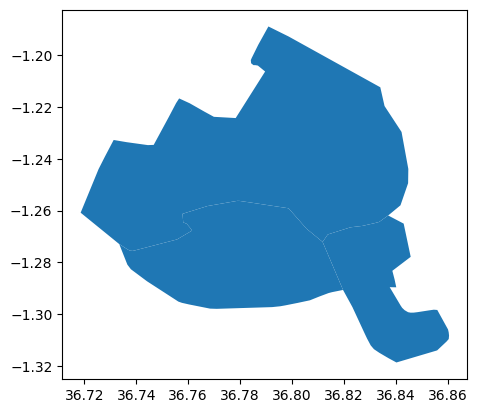

In [4]:
nairobi_gdf = gaul_gdf[gaul_gdf['gaul1_name'] == 'Nairobi']
roi_gdf = nairobi_gdf[nairobi_gdf['gaul2_name'].isin(["Starehe", "Westlands", "Kilimani"])]
roi_gdf.plot()

In [5]:
bbox = roi_gdf.total_bounds.tolist()  # [minx, miny, maxx, maxy]
utm_crs = get_utm_crs(bbox)
utm_crs

'EPSG:32737'

## GEE Request Example

In [46]:
spectral_indexes = ['NDVI', 'NDBI']
imagery_ee_path = 'COPERNICUS/S2_HARMONIZED'
cloud_coverage = 10
start_date = '2017-01-01'
end_date = '2017-12-31'

In [ ]:
roi_ic = request_gee_image(imagery_ee_path, start_date, end_date, bbox)

In [ ]:
imagery_ic = (roi_ic \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_coverage)) \
    .spectralIndices(spectral_indexes).mean() \
    .select(spectral_indexes))

In [49]:
ic_da = extract_imagery(imagery_ic, bbox, utm_crs, 10)

/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


In [50]:
ic_da.rio.to_raster('spectral_nairobi_2017.tif')

## Visualisation

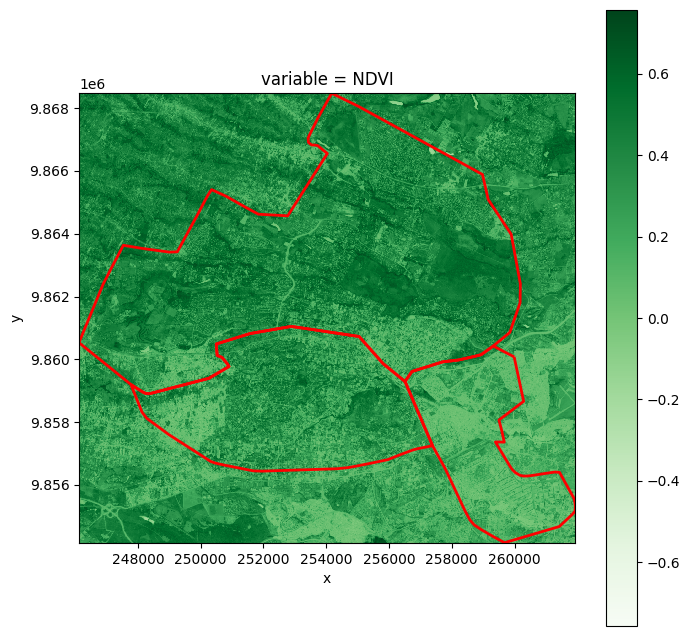

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
ic_da.sel(variable='NDVI').plot(ax=ax, cmap='Greens')
roi_gdf.to_crs(utm_crs).boundary.plot(ax=ax, color='red', linewidth=2)
plt.show()

# Functions Usage
## Spectral with Sentinel 2

In [ ]:
imagery_ee_path = 'COPERNICUS/S2_HARMONIZED'
spectral_indexes = ['NDVI', 'NDBI']
cloud_coverage = 10
scale = 10

for year in range(2016, 2026):
    print(f'Processing {year}')
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    roi_ic = request_gee_image(imagery_ee_path, start_date, end_date, bbox)
    imagery_ic = (roi_ic \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_coverage)) \
        .spectralIndices(spectral_indexes).mean() \
        .select(spectral_indexes))
    ic_da = extract_imagery(imagery_ic, bbox, utm_crs, scale)
    ic_da.rio.to_raster(f'../images/spectral_nairobi_{year}_sentinel2.tif')


Processing 2016


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2017


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2018


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2019


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2020


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2021


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2022


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2023


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2024


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2025


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


## Spectral with Landsat 8

In [ ]:
imagery_ee_path = 'LANDSAT/LC08/C02/T1_L2'
spectral_indexes = ['NDVI', 'NDBI']
cloud_coverage = 20
scale = 30

for year in range(2016, 2026):
    print(f'Processing {year}')
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    roi_ic = request_gee_image(imagery_ee_path, start_date, end_date, bbox)
    imagery_ic = (roi_ic \
        .filter(ee.Filter.lt('CLOUD_COVER', cloud_coverage)) \
        .spectralIndices(spectral_indexes).mean() \
        .select(spectral_indexes))
    ic_da = extract_imagery(imagery_ic, bbox, utm_crs, scale)
    ic_da.rio.to_raster(f'../images/spectral_nairobi_{year}_landsat8.tif')

Processing 2016


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2017


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2018


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2019


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2020


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2021


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2022


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2023


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2024


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2025


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


## LST with Landsat 8

In [ ]:
imagery_ee_path = 'LANDSAT/LC08/C02/T1_L2'
cloud_coverage = 20
scale = 30

for year in range(2016, 2026):
    print(f'Processing {year}')
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    roi_ic = request_gee_image(imagery_ee_path, start_date, end_date, bbox)
    imagery_ic = roi_ic.filter(ee.Filter.lt('CLOUD_COVER', cloud_coverage)).mean()
    lst_ic = calculate_lst(imagery_ic)
    lst_da = extract_imagery(lst_ic, bbox, utm_crs, scale)
    lst_da.rio.to_raster(f'../images/lst_nairobi_{year}_landsat8.tif')

Processing 2016


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2017


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2018


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2019


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2020


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2021


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2022


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2023


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2024


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


Processing 2025


/maps/acz25/envs/lcz-eofm-env/lib/python3.12/site-packages/xee/ext.py:688: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


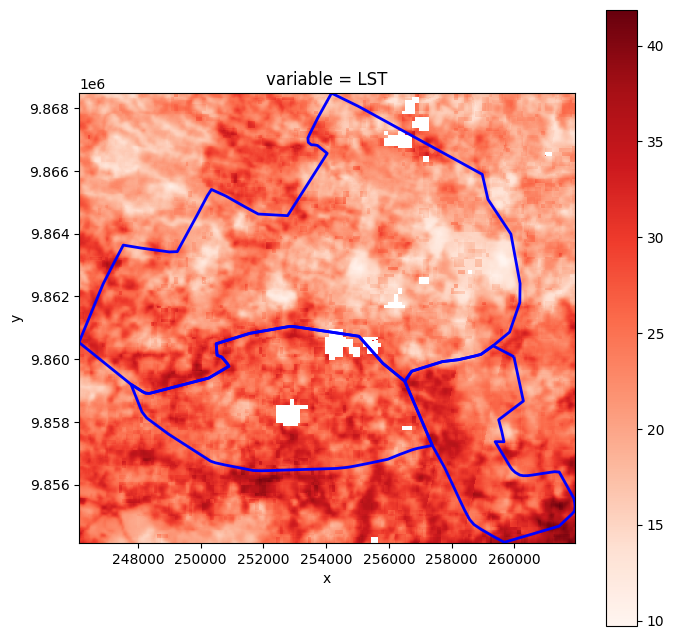

In [102]:
fig, ax = plt.subplots(figsize=(8, 8))
lst_da.sel(variable='LST').plot(ax=ax, cmap='Reds')
roi_gdf.to_crs(utm_crs).boundary.plot(ax=ax, color='blue', linewidth=2)
plt.show()

# Sample points (Landsat 8)

In [27]:
imagery_ee_path = 'LANDSAT/LC08/C02/T1_L2'
spectral_indexes = ['NDVI', 'NDBI']
cloud_coverage = 20
scale = 30
year = 2016

print(f'Processing {year}')
start_date = f'{year}-01-01'
end_date = f'{year}-12-31'
roi_ic = request_gee_image(imagery_ee_path, start_date, end_date, bbox)
spectral_ic = (roi_ic \
    .filter(ee.Filter.lt('CLOUD_COVER', cloud_coverage)) \
    .spectralIndices(spectral_indexes).mean() \
    .select(spectral_indexes))

imagery_ic = roi_ic.filter(ee.Filter.lt('CLOUD_COVER', cloud_coverage)).mean()
lst_ic = calculate_lst(imagery_ic)

roi_image_ic = spectral_ic.addBands(lst_ic)

Processing 2016


In [28]:
sample_points_ee = roi_image_ic.sample(
    region=ee.Geometry.Rectangle([bbox[:2], bbox[2:]]), 
    scale=30, 
    numPixels=1000, 
    geometries=True # Keeps the lat/long
)

cleaned_samples = sample_points_ee.map(get_sample_info)

data = [feat['properties'] for feat in cleaned_samples.getInfo()['features']]
sample_df = pd.DataFrame(data)
sample_df['year'] = year

In [29]:
sample_gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.lon, sample_df.lat), crs='EPSG:4326')
sample_gdf = sample_gdf.sjoin(roi_gdf[['gaul2_name', 'geometry']], how='left')
sample_gdf['gaul2_name'] = sample_gdf['gaul2_name'].fillna('Outside')

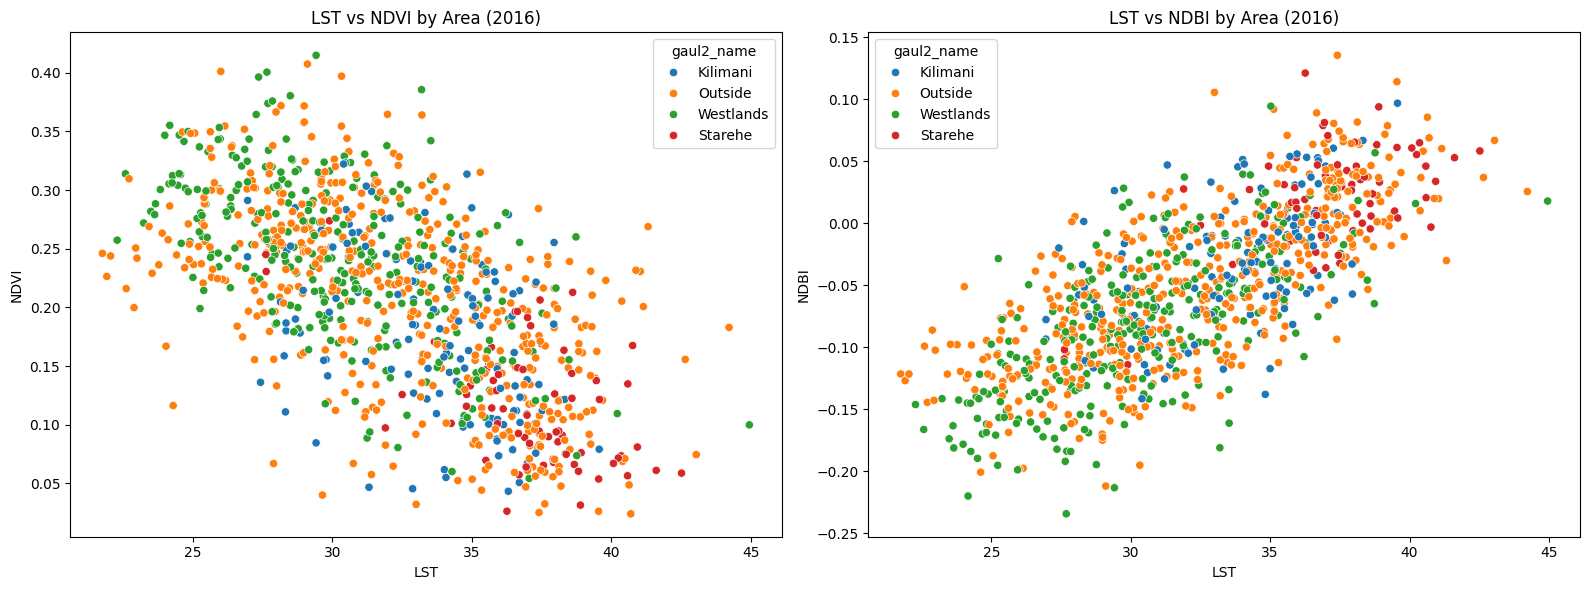

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# NDVI vs LST by Area
sns.scatterplot(data=sample_gdf, x='LST', y='NDVI', hue='gaul2_name', ax=axes[0])
axes[0].set_title(f'LST vs NDVI by Area ({year})')

# NDBI vs LST by Area
sns.scatterplot(data=sample_gdf, x='LST', y='NDBI', hue='gaul2_name', ax=axes[1])
axes[1].set_title(f'LST vs NDBI by Area ({year})')

plt.tight_layout()
plt.show()

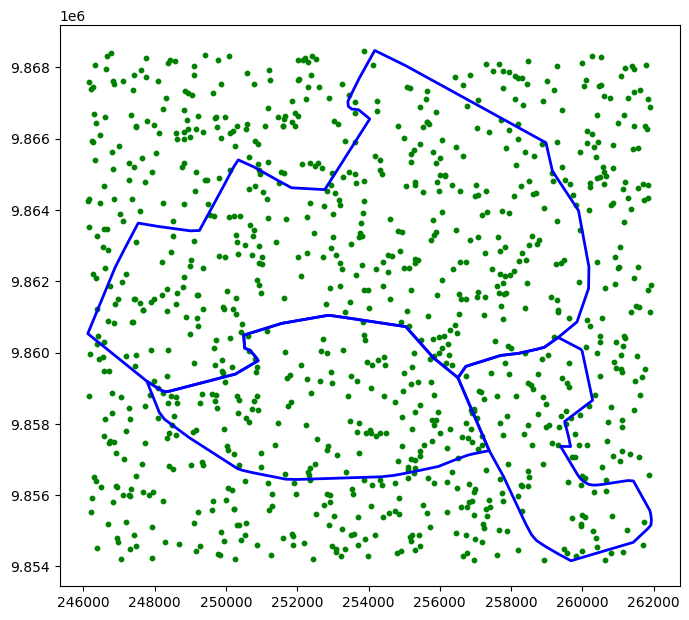

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
roi_gdf.to_crs(utm_crs).boundary.plot(ax=ax, color='blue', linewidth=2)
sample_gdf.to_crs(utm_crs).plot(ax=ax, color='green', markersize=10)
plt.show()